In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import copy
import sys
sys.path.append('/home2/ebrahim/neural_seq_decoder/scripts/')
from load_data import map_from_channel_index_to_brain_area
from sklearn.decomposition import PCA
import pandas as pd
import scipy

In [17]:
import scipy.ndimage

def halfgaussian_kernel1d(sigma, radius):
    """
    Computes a 1-D Half-Gaussian convolution kernel.
    """
    sigma2 = sigma * sigma
    x = np.arange(0, radius+1)
    phi_x = np.exp(-0.5 / sigma2 * x ** 2)
    phi_x = phi_x / phi_x.sum()

    return phi_x

def halfgaussian_filter1d(input, sigma, axis=-1, output=None,
                      mode="constant", cval=0.0, truncate=4.0):
    """
    Convolves a 1-D Half-Gaussian convolution kernel.
    """
    sd = float(sigma)
    # make the radius of the filter equal to truncate standard deviations
    lw = int(truncate * sd + 0.5)
    weights = halfgaussian_kernel1d(sigma, lw)
    origin = -lw // 2
    return scipy.ndimage.convolve1d(input, weights, axis, output, mode, cval, origin)

In [4]:
savePath = '/data/LLMs/willet/regression_data/'
dataFolder = '/data/LLMs/willet/regression_data'

In [5]:
trialState = np.load('/data/LLMs/willet/data/trialState.npy')
block_sess = np.load('/data/LLMs/willet/block_sess.npy')
ba6 = np.load('/data/LLMs/willet/regression_data/smooth_ba6v_pow.npy')

audioEnvelope = np.load('/data/LLMs/willet/data/audioEnvelope.npy')
session = np.load('/data/LLMs/willet/session.npy')

### Audio features

In [6]:
go_period_idxs = np.argwhere(trialState==1).squeeze()
audio_go = np.zeros_like(audioEnvelope)
audio_go[go_period_idxs] = audioEnvelope[go_period_idxs]

In [10]:
sigma = [0,5, 10, 20]
delays = [0,5,10,15] # 0, 100ms, 200ms, and 300ms delays
audio_features = {}

for s in sigma:
    for d in delays:
         audio_features[f"{s}_{d}"] = np.zeros_like(audio_go).squeeze()
        

for i, bs in enumerate(np.unique(block_sess)):
    
    block_sess_idxs = np.argwhere(block_sess==bs).squeeze()
    audio_go_bs = audio_go[block_sess_idxs]
    
    for s in sigma:
        
        for d in delays:
            
            if s != 0:
                audio_go_smooth = gaussian_filter1d(audio_go_bs, sigma=s)
            else:
                audio_go_smooth = copy.deepcopy(audio_go_bs)
            
            audio_go_smooth_delayed = np.pad(audio_go_smooth[d:], (0,d))
        
            audio_features[f"{s}_{d}"][block_sess_idxs] = (audio_go_smooth_delayed - np.mean(audio_go_smooth_delayed))/np.std(audio_go_smooth_delayed)


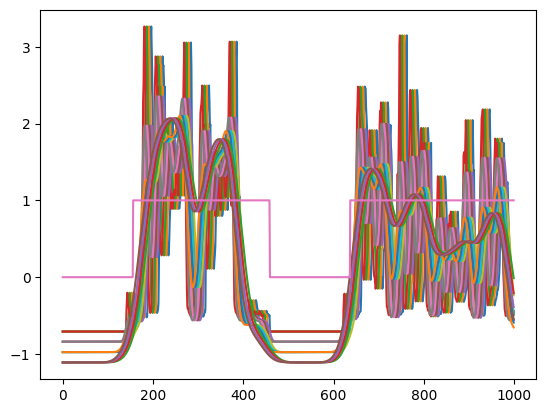

In [7]:
# audio_features_np has shape (n_time_points, n_features)
# Compute the mean and standard deviation along the time dimension (axis=0)
audio_features_np = np.zeros((audio_go.shape[0], len(sigma)*len(delays)))
c = 0
for s in sigma:
    for d in delays:
        audio_features_np[:, c] = audio_features[f"{s}_{d}"]
        c+=1 

np.save('/data/LLMs/willet/regression_data/audio_features', audio_features_np)
plt.plot(audio_features_np[0:1000])
plt.plot(trialState[0:1000]*1)
plt.show()

In [8]:
trialState_binary = np.expand_dims(np.zeros_like(trialState),axis=-1)
trialState_binary[trialState==1] = 1
np.save('/data/LLMs/willet/regression_data/go', trialState_binary)

In [10]:
go_audio = np.hstack((trialState_binary, audio_features_np))
np.save('/data/LLMs/willet/regression_data/go_audio', go_audio)

In [5]:
load_non_smooth_data = True
if load_non_smooth_data:
    ba44 = np.load("/data/LLMs/willet/regression_data/ba44_nosmooth.npy")
else:
    ba44 = np.load('/data/LLMs/willet/regression_data/smooth_ba44_pow.npy')

In [6]:
val_sessions = np.load('/data/LLMs/willet/val_sess.npy')

In [7]:
6 * 128

768

In [8]:
sigma = [2]
delays = [0,5,10,15,20,25] # do delays in increments of 200ms (0,400,800,1200)
ba44_features = {}

for s in sigma:
    for d in delays:
        ba44_features[f"{s}_{d}"] = np.empty((ba44.shape[0], ba44.shape[1]))

In [9]:
val_mode = True

In [10]:
num_blocks = np.unique(block_sess).shape[0]
for i, bs in enumerate(np.unique(block_sess)):
    
    sess_selected = bs.split('_')[1]
    
    if val_mode:
        if sess_selected not in val_sessions:
            continue
    
    print(f"block {i} out of {num_blocks}")
    
    # indices corresponding to block and session 
    block_sess_idxs = np.argwhere(block_sess==bs).squeeze()
    # select ba44 data
    ba_44_neural_bs = ba44[block_sess_idxs]
    
    for s in sigma:
        
        if s != 0:
            ba_44_smooth = halfgaussian_filter1d(ba_44_neural_bs, sigma=s, axis=0)
        else:
            ba_44_smooth = copy.deepcopy(ba_44_neural_bs)
    
        for d in delays:
            
            padding_amount = np.zeros((d, ba_44_smooth.shape[1]))
            
            if d != 0:
                ba_44_smooth_delayed = np.vstack((padding_amount, ba_44_smooth[:-d]))
            else:
                ba_44_smooth_delayed = ba_44_smooth
        
            ba44_features[f"{s}_{d}"][block_sess_idxs] = ba_44_smooth_delayed.astype('float32')


block 1 out of 306
block 4 out of 306
block 11 out of 306
block 18 out of 306
block 21 out of 306
block 24 out of 306
block 31 out of 306
block 33 out of 306
block 39 out of 306
block 42 out of 306
block 45 out of 306
block 52 out of 306
block 60 out of 306
block 63 out of 306
block 66 out of 306
block 71 out of 306
block 72 out of 306
block 78 out of 306
block 81 out of 306
block 84 out of 306
block 88 out of 306
block 90 out of 306
block 97 out of 306
block 104 out of 306
block 110 out of 306
block 113 out of 306
block 118 out of 306
block 120 out of 306
block 125 out of 306
block 128 out of 306
block 130 out of 306
block 134 out of 306
block 135 out of 306
block 141 out of 306
block 143 out of 306
block 145 out of 306
block 148 out of 306
block 152 out of 306
block 154 out of 306
block 156 out of 306
block 158 out of 306
block 160 out of 306
block 163 out of 306
block 169 out of 306
block 172 out of 306
block 175 out of 306
block 183 out of 306
block 188 out of 306
block 191 out of 

In [11]:
perform_pca = False
saveName = 'scratch'
N = 400

In [14]:
c = 0
for sess in np.unique(session):
    
    if val_mode:
        if sess not in val_sessions:
            continue
    
    sess_idxs = np.argwhere(session==sess).squeeze()
    single_sess = []
    
    for s in sigma:
        for d in delays:
           single_sess.append(ba44_features[f"{s}_{d}"][sess_idxs])
           
    sess_data = np.hstack(single_sess)
    np.save(f'/data/LLMs/willet/regression_data/ba44_{saveName}_{sess}', np.hstack((single_sess)))


In [15]:
sess_data.shape

(309848, 768)

In [39]:
ba_6v_superior = []
ba_6v_inferior = []
for i in range(ba6.shape[1]):
    index = map_from_channel_index_to_brain_area(i)
    if index == 'ip_6v' or index=='ia_6v':
        ba_6v_inferior.append(i)
    else:
        ba_6v_superior.append(i)

In [40]:
ba6v_inferior_neural = ba6[:, np.array(ba_6v_inferior)]
ba6v_superior_neural = ba6[:, np.array(ba_6v_superior)]
np.save(f"{savePath}/ba6v_inferior", ba6v_inferior_neural)
np.save(f"{savePath}/ba6v_superior", ba6v_superior_neural)

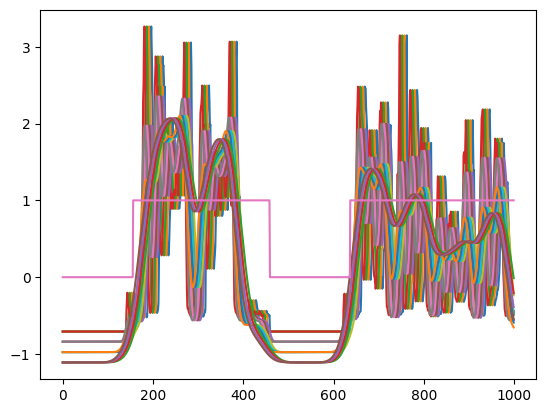

In [7]:
sigma = [0,5,10,20]
delays = [0,5,10,15] # 0, 100ms, 200ms, and 300ms delays forward
audio_features = {}

for s in sigma:
    for d in delays:
         audio_features[f"{s}_{d}"] = np.zeros_like(audio_go).squeeze()
        

for i, bs in enumerate(np.unique(block_sess)):
    
    block_sess_idxs = np.argwhere(block_sess==bs).squeeze()
    audio_go_bs = audio_go[block_sess_idxs]
    
    for s in sigma:
        
        for d in delays:
            
            if s != 0:
                audio_go_smooth = gaussian_filter1d(audio_go_bs, sigma=s)
            else:
                audio_go_smooth = copy.deepcopy(audio_go_bs)
            
            audio_go_smooth_delayed = np.pad(audio_go_smooth[d:], (0,d))
        
            audio_features[f"{s}_{d}"][block_sess_idxs] = (audio_go_smooth_delayed - np.mean(audio_go_smooth_delayed))/np.std(audio_go_smooth_delayed)
# audio_features_np has shape (n_time_points, n_features)
# Compute the mean and standard deviation along the time dimension (axis=0)
audio_features_np = np.zeros((audio_go.shape[0], len(sigma)*len(delays)))
c = 0
for s in sigma:
    for d in delays:
        audio_features_np[:, c] = audio_features[f"{s}_{d}"]
        c+=1 

np.save('/data/LLMs/willet/regression_data/audio_features', audio_features_np)
plt.plot(audio_features_np[0:1000])
plt.plot(trialState[0:1000]*1)
plt.show()

In [10]:
trialState_binary = np.zeros_like(trialState)
trialState_binary[trialState_binary!=1] = 0 # only encode the go cue

In [44]:
np.save('/data/LLMs/willet/regression_data/go_audio', np.hstack((trialState_binary, audio_features_np)))

In [45]:
np.save('/data/LLMs/willet/regression_data/ba44_go', np.hstack((ba44, trialState_binary)))

In [50]:
np.save('/data/LLMs/willet/regression_data/ba6vsup_go_audio', np.hstack((ba6v_superior_neural, trialState_binary, standardized_audio_features_np)))